In [7]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.utils import np_utils

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gc


В работе использовались:

1. Материалы лекций
2. Помощь лампового чата
3. Примеры от https://github.com/Orbifold

# Предобработка данных

Данные представлены файлом весом ≈1.5ГБ, в котором содержится много избыточной информации. Поэтому заранее преобразуем его, оставляя только поля *text* и *rating* в формате tsv. Для экономии времени был написан скрипт на Node.js, он выложен на GitHub.

In [8]:
data = pd.read_csv('result.tsv', sep='\t', names = ['rating', 'text'])
MAX_FEATURES = 5
data.head()

,rating,text
0,1,1 июня 2015 в Москве в отделении по адресу Смо...
1,5,Здравствуйте! Хотелось бы выразить благодарно...
2,2,Уважаемые представители департамента по работе...
3,2,Здравствуйте. Столкнулась с такой ситуацией. в...
4,1,История очень долгая! Пришел я в банк (это раз...


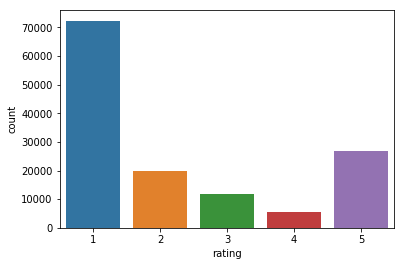

In [9]:
sns.countplot(x="rating", data=data)

Как видно классы сильно несбалансированы. Количество отрицательных отзывов превалирует над количеством остальных.

Попробуем проанализировать тексты набора данных по длине

In [10]:
data = data.assign(text_word_count = data.text.apply(lambda text: len(text.split())))

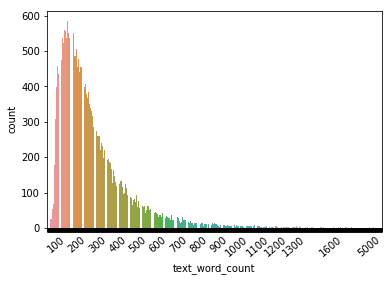

In [11]:
ax = sns.countplot(x="text_word_count", data=data)
original_labels = sorted(data.text_word_count.value_counts().index)
labels = list(map(lambda l: l if l % 100 == 0 else ' ', original_labels))
ax.set_xticklabels(labels, rotation=40, ha="right")
plt.show()

Подберём оптимальное окно длин текстов, чтобы сохранить 85% отзывов

In [12]:
%%time

length_frequencies = dict(data.text_word_count.value_counts())

def get_coverage(from_value, to_value):
    return sum([freq if length >= from_value and length <= to_value else 0 for length, freq in length_frequencies.items()]) / len(data)

lengths = length_frequencies.keys()
min_length = 50
max_length = 500
from_length, to_length = min(lengths), max_length

for first_length in lengths:
    for second_length in lengths:
        if first_length < second_length and second_length <= max_length:
            coverage = get_coverage(first_length, second_length)
            if coverage >= 0.85 and second_length - first_length < to_length - from_length:
                from_length, to_length = first_length, second_length
                            
print(from_length, to_length, get_coverage(from_length, to_length))


40 385 0.850019826991144
CPU times: user 1min, sys: 549 ms, total: 1min
Wall time: 1min 4s


In [13]:
data = data[data.text_word_count >= from_length][data.text_word_count < to_length]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [14]:
train_data, test_data = train_test_split(data, test_size=0.2)
del data
gc.collect()

44

# Baseline-алгоритм

In [15]:
%%time

import numpy as np
emb_path = '../wiki.ru.vec'

words = []

embeddings_index = {}
f = open(emb_path)
for line in f:
    values = line.split()
    if len(values) == 301:
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

CPU times: user 3min 43s, sys: 13.3 s, total: 3min 56s
Wall time: 4min 39s


In [16]:
%%time

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
tokenizer.fit_on_texts(test_data.text)

CPU times: user 52.5 s, sys: 3.71 s, total: 56.2 s
Wall time: 1min 5s


In [17]:
%%time

word_index = tokenizer.word_index
embedding_dimension = len(embeddings_index['the'])
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector[:embedding_dimension]
import gc
del embeddings_index
gc.collect()

CPU times: user 3.79 s, sys: 6.15 s, total: 9.94 s
Wall time: 13.7 s


In [18]:
%%time

train_data_X = tokenizer.texts_to_sequences(train_data.text)
test_data_X = tokenizer.texts_to_sequences(test_data.text)

train_maxlen = max([len(sequence) for sequence in train_data_X])
test_maxlen = max([len(sequence) for sequence in test_data_X])
maxlen = max([train_maxlen, test_maxlen])

train_data_X = pad_sequences(train_data_X, maxlen=maxlen)
test_data_X = pad_sequences(train_data_X, maxlen=maxlen)

CPU times: user 40.9 s, sys: 1.71 s, total: 42.6 s
Wall time: 45.4 s


In [19]:
train_data_y = np_utils.to_categorical(train_data.rating - 1)
test_data_y = np_utils.to_categorical(train_data.rating - 1)

In [ ]:
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.fit(train_data_X, y=train_data_y, batch_size=32, epochs=10, validation_split=0.2, shuffle=True)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 74004 samples, validate on 18502 samples
Epoch 1/10
24928/74004 [=========>....................] - ETA: 9:46 - loss: 1.0368 - acc: 0.6457